Copyright (c) 2020-2021 Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# AutoVW: ChaCha for Online AutoML with Vowpal Wabbit


## 1. Introduction


In this notebook, we use one real data example (regression task) to showcase AutoVW, which is an online AutoML solution based on the following work:

*ChaCha for online AutoML. Qingyun Wu, Chi Wang, John Langford, Paul Mineiro and Marco Rossi. To appear in ICML 2021.*

AutoVW is implemented in FLAML. FLAML requires `Python>=3.6`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook]
```

In [ ]:
!pip install flaml[notebook];

## 2. Online regression with AutoVW
### Load data from openml and preprocess

Download [dataset_sales](https://www.openml.org/d/42183) from OpenML.

In [2]:
import openml
# did = 42183
did = 41506
ds = openml.datasets.get_dataset(did)
target_attribute = ds.default_target_attribute
data = ds.get_data(target=target_attribute, dataset_format='array')
X, y = data[0], data[1]
print(X.shape, y.shape)

(36203, 17) (36203,)


Convert the openml dataset into vowpalwabbit examples:
Sequentially group features into up to 10 namespaces and convert the original data examples into vowpal wabbit format.

In [3]:
import numpy as np
import string
NS_LIST = list(string.ascii_lowercase) + list(string.ascii_uppercase)
max_ns_num = 10 # the maximum number of namespaces
orginal_dim = X.shape[1]
max_size_per_group = int(np.ceil(orginal_dim / float(max_ns_num)))
# sequential grouping
group_indexes = []
for i in range(max_ns_num):
    indexes = [ind for ind in range(i * max_size_per_group,
                min((i + 1) * max_size_per_group, orginal_dim))]
    if len(indexes) > 0:
        group_indexes.append(indexes)

vw_examples = []
for i in range(X.shape[0]):
    ns_content = []
    for zz in range(len(group_indexes)):
        ns_features = ' '.join('{}:{:.6f}'.format(ind, X[i][ind]) for ind in group_indexes[zz])
        ns_content.append(ns_features)
    ns_line = '{} |{}'.format(str(y[i]), '|'.join('{} {}'.format(NS_LIST[j], ns_content[j]) for j in range(len(group_indexes))))
    vw_examples.append(ns_line)
print('openml example:', y[0], X[0])
print('vw example:', vw_examples[0])

openml example: 8.170000076293945 [1.0000e+01 7.0000e+00 3.0000e+00 4.0000e+00        nan 6.3300e+00
 1.3600e-01 7.3300e+00 7.0100e+00 6.9800e+00 3.0000e-03 7.0000e+00
 9.7000e+00 1.2300e+01 1.0217e+03 0.0000e+00 5.8000e+01]
vw example: 8.170000076293945 |a 0:10.000000 1:7.000000|b 2:3.000000 3:4.000000|c 4:nan 5:6.330000|d 6:0.136000 7:7.330000|e 8:7.010000 9:6.980000|f 10:0.003000 11:7.000000|g 12:9.700000 13:12.300000|h 14:1021.700012 15:0.000000|i 16:58.000000


### Set up the online learning loop


In [4]:
from sklearn.metrics import mean_squared_error
def online_learning_loop(iter_num, vw_examples, vw_alg):
    """Implements the online learning loop.
    """
    print('Online learning for', iter_num, 'steps...')
    loss_list = []
    y_predict_list = []
    for i in range(iter_num):
        vw_x = vw_examples[i]
        y_true = float(vw_examples[i].split('|')[0])
        # predict step
        y_pred = vw_alg.predict(vw_x)
        # learn step
        vw_alg.learn(vw_x)
        # calculate one step loss
        loss = mean_squared_error([y_pred], [y_true])
        loss_list.append(loss)
        y_predict_list.append([y_pred, y_true])
    return loss_list

max_iter_num = 10000  # or len(vw_examples)

### Vanilla VW
Create and run a vanilla vowpal wabbit learner.

In [5]:
from vowpalwabbit import pyvw
''' create a vanilla vw instance '''
vanilla_vw = pyvw.vw()

loss_list_vanilla = online_learning_loop(max_iter_num, vw_examples, vanilla_vw)
print('Final progressive validation loss of vanilla vw:', sum(loss_list_vanilla)/len(loss_list_vanilla))

Online learning for 10000 steps...
Final progressive validation loss of vanilla vw: 15.180878192648041


### AutoVW which tunes namespace interactions  
Create and run an AutoVW instance which tunes namespace interactions. Each AutoVW instance allows ```max_live_model_num``` of VW models (each associated with its own hyperaparameter configurations that are tuned online) to run concurrently in each step of the online learning loop.

In [6]:
''' import AutoVW class from flaml package '''
from flaml import AutoVW
from flaml.tune import polynomial_expansion_set, loguniform

'''create an AutoVW instance for tuning namespace interactions'''
# set up the init config and search space
raw_namespaces = AutoVW.get_ns_feature_dim_from_vw_example(vw_examples[0]).keys()
# create an AutoVW instance
autovw_ni = AutoVW(max_live_model_num=5, 
                   search_space={'interactions': polynomial_expansion_set(init_monomials=set(raw_namespaces))})

# online learning with AutoVW
loss_list_autovw_ni = online_learning_loop(max_iter_num, vw_examples, autovw_ni)
print('Final progressive validation loss of autovw:', sum(loss_list_autovw_ni)/len(loss_list_autovw_ni))

Seed namespaces (singletons and interactions): ['a', 'i', 'c', 'b', 'e', 'f', 'h', 'g', 'd']
Created challengers from champion |
New challenger size 37, ['|bc', '|fh', '|hi', '|fi', '|ad', '|df', '|dh', '|dg', '|ae', '|bg', '|ei', '|cd', '|ac', '|bd', '|gi', '|ch', '|gh', '|cg', '|fg', '|ce', '|ai', '|ah', '|cf', '|eh', '|bf', '|ef', '|eg', '|de', '|di', '|ag', '|ab', '|af', '|bi', '|bh', '|ci', '|be', '|']
Online learning for 10000 steps...
Seed namespaces (singletons and interactions): ['ci', 'a', 'i', 'c', 'b', 'e', 'f', 'h', 'g', 'd']
Created challengers from champion |ci
New challenger size 43, ['|ag_ci', '|ci_de', '|ci_gh', '|cd_ci', '|ci_ef', '|ch_ci', '|bg_ci', '|bi_ci', '|cdi_ci', '|ci_fg', '|ce_ci', '|be_ci', '|bci_ci', '|ci', '|chi_ci', '|bc_ci', '|ci_hi', '|cfi_ci', '|ci_dh', '|ci_fi', '|cg_ci', '|aci_ci', '|ci_di', '|ci_gi', '|bh_ci', '|ci_dg', '|cgi_ci', '|ci_eg', '|ci_ei', '|ae_ci', '|ad_ci', '|ac_ci', '|af_ci', '|ah_ci', '|cei_ci', '|cf_ci', '|ai_ci', '|bd_ci', '|ci_fh'

### AutoVW which tunes both namespace interactions and learning rate
Create and run an AutoVW instance which tunes both namespace interactions and learning rate.

In [7]:

''' create another AutoVW instance for tuning namespace interactions and learning rate'''
# set up the init config and search space
init_config_nilr = {'interactions': set(), 'learning_rate': 0.5}
search_space_nilr = {'interactions': polynomial_expansion_set(init_monomials=set(raw_namespaces)),
'learning_rate': loguniform(lower=2e-10, upper=1.0)}
# create an AutoVW instance
autovw_nilr = AutoVW(max_live_model_num=5, search_space=search_space_nilr, init_config=init_config_nilr)

# online learning with AutoVW
loss_list_autovw_nilr = online_learning_loop(max_iter_num, vw_examples, autovw_nilr)
print('Final progressive validation loss of autovw_nilr:', sum(loss_list_autovw_nilr)/len(loss_list_autovw_nilr))


Seed namespaces (singletons and interactions): ['a', 'i', 'c', 'b', 'e', 'f', 'h', 'g', 'd']
No low-cost init config given to the search algorithm.For cost-frugal search, consider providing init values for cost-related hps via 'init_config'.
Created challengers from champion ||0.5
New challenger size 39, ['|bf|0.5', '|cf|0.5', '|ce|0.5', '|cd|0.5', '|ah|0.5', '|ch|0.5', '|ab|0.5', '|bi|0.5', '|ai|0.5', '|ei|0.5', '|ef|0.5', '|de|0.5', '|be|0.5', '|dh|0.5', '|ag|0.5', '|bg|0.5', '|bh|0.5', '|dg|0.5', '|df|0.5', '|di|0.5', '|ac|0.5', '|cg|0.5', '|ci|0.5', '|bd|0.5', '|gh|0.5', '|af|0.5', '|hi|0.5', '|ad|0.5', '|fh|0.5', '|gi|0.5', '|fi|0.5', '|eh|0.5', '|bc|0.5', '|fg|0.5', '|eg|0.5', '|ae|0.5', '||0.05358867312681484', '||1.0', '||0.5']
Online learning for 10000 steps...
Seed namespaces (singletons and interactions): ['a', 'i', 'c', 'b', 'e', 'f', 'h', 'g', 'd']
No low-cost init config given to the search algorithm.For cost-frugal search, consider providing init values for cost-related 

### Online performance comparison
Compare the online progressive validation loss from the vanilla VW and two AutoVW instances.

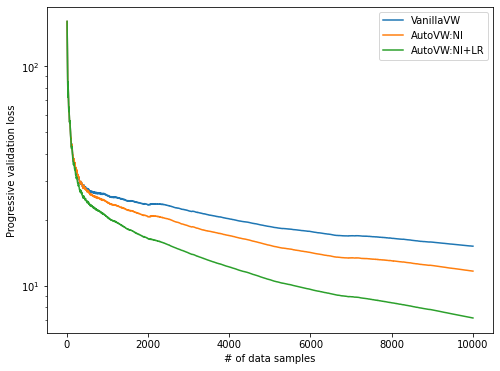

In [8]:
import matplotlib.pyplot as plt
def plot_progressive_loss(obj_list, alias, result_interval=1,):
    """Show real-time progressive validation loss
    """
    avg_list = [sum(obj_list[:i]) / i for i in range(1, len(obj_list))]
    total_obs = len(avg_list)
    warm_starting_point = 10 #0
    plt.plot(range(warm_starting_point, len(avg_list)), avg_list[warm_starting_point:], label = alias)
    plt.xlabel('# of data samples',)
    plt.ylabel('Progressive validation loss')
    plt.yscale('log')
    plt.legend(loc='upper right')
plt.figure(figsize=(8, 6))
plot_progressive_loss(loss_list_vanilla, 'VanillaVW')
plot_progressive_loss(loss_list_autovw_ni, 'AutoVW:NI')
plot_progressive_loss(loss_list_autovw_nilr, 'AutoVW:NI+LR')
plt.show()

### AutoVW based on customized VW arguments
You can easily create an AutoVW instance based on customized VW arguments (For now only arguments that are compatible with supervised regression task are well supported). The customized arguments can be passed to AutoVW through init_config and search space.

In [9]:
''' create an AutoVW instance with ustomized VW arguments'''
# parse the customized VW arguments
fixed_vw_hp_config = {'alg': 'supervised', 'loss_function': 'classic'}
search_space = fixed_vw_hp_config.copy()
search_space.update({'interactions': polynomial_expansion_set(init_monomials=set(raw_namespaces))})

autovw_custom = AutoVW(max_live_model_num=5, search_space=search_space) 
loss_list_custom = online_learning_loop(max_iter_num, vw_examples, autovw_custom)
print('Average final loss of the AutoVW (tuning namespaces) based on customized vw arguments:', sum(loss_list_custom)/len(loss_list_custom))


Seed namespaces (singletons and interactions): ['a', 'i', 'c', 'b', 'e', 'f', 'h', 'g', 'd']
Created challengers from champion |supervised||classic
New challenger size 37, ['|supervised|bh|classic', '|supervised|fh|classic', '|supervised|fg|classic', '|supervised|bg|classic', '|supervised|ag|classic', '|supervised|cg|classic', '|supervised|de|classic', '|supervised|be|classic', '|supervised|cd|classic', '|supervised|bd|classic', '|supervised|dg|classic', '|supervised|ah|classic', '|supervised|dh|classic', '|supervised|bf|classic', '|supervised|df|classic', '|supervised|ae|classic', '|supervised|bi|classic', '|supervised|di|classic', '|supervised|af|classic', '|supervised|ad|classic', '|supervised|ce|classic', '|supervised|gh|classic', '|supervised|ai|classic', '|supervised|ei|classic', '|supervised|ef|classic', '|supervised|eh|classic', '|supervised|eg|classic', '|supervised|ab|classic', '|supervised|ch|classic', '|supervised|hi|classic', '|supervised|bc|classic', '|supervised|gi|class